# Undistortion and platescale measurements of FDT commissioning and cruise phase data

In [1]:
import numpy as np
import pyfits

import matplotlib.pyplot as plt
import skimage
from skimage.feature import blob_dog, blob_doh, blob_log, canny
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.segmentation import slic
from skimage.filters import sobel
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage import measure
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

## This inverse function is based on solving the forward distortion equation for $r_d$ 

In [2]:
## choose x_u, y_d from (0,2048)

def Inv3(x_c,y_c,x_u,y_u,k):
  x_u = x_u-x_c
  y_u = y_u - y_c
  r_u = np.sqrt((x_u)**2+(y_u)**2)
  delta = (1./(3*k))**3 + (r_u/(2*k))**2
  r_d = np.cbrt((r_u/2*k) + np.sqrt(delta))  + (1./(3*k))*1/(np.cbrt( r_u/(2*k) + np.sqrt(delta) ))
  M = (1./(1+k*r_d**2))
  x_d = (x_u)*M
  y_d = (y_u)*M
  x_d = x_d + x_c
  y_d = y_d+y_c
  return x_d,y_d

In [3]:
def Inv2(x_c,y_c,x_u,y_u,k):
  r_u = np.sqrt((x_u-x_c)**2+(y_u-y_c)**2) 
  x_d = x_c+(x_u-x_c)*(1-k*r_u**2)
  y_d = y_c+(y_u-y_c)*(1-k*r_u**2)
  return x_d,y_d
    


In [4]:
# based on park et al:
def Inv(x_c,y_c,x_u,y_u,k):
    x_u = x_u-x_c
    y_u = y_u - y_c
    r_u = np.sqrt((x_u)**2+(y_u**2))
    r_d = (-1+np.sqrt(1+4*k*r_u**2))/(2*k*r_u)
    M = (-1+np.sqrt(1+4*k*r_u**2))/(2*k*r_u**2)#1./(1+k*r_d**2) #r_d/r_u#
    x_d = x_u*M
    y_d = y_u*M
    x_d = x_d + x_c
    y_d = y_d+y_c
    return x_d,y_d

# Bi-linear interpolation of the distorted image given an inversion function

In [5]:
x = y = np.arange(2048)
x_c =1023+33
y_c = 1023+89
k=1.9*10**(-8)
output_inv = np.zeros((2048,2048))
Nx = Ny=2048

In [159]:
x_c, y_c

(1056, 1112)

In [7]:
## bilinear interpolation
from scipy import interpolate
path_03 = '/home/fatima/Desktop/solar_orbiter_project/commissioning/phi-3/'
path_02 = '/home/fatima/Desktop/solar_orbiter_project/commissioning/phi-2/'
path_fdt = '/home/fatima/Desktop/solar_orbiter_project/commissioning/IP-FDT/'



In [8]:
#d = pyfits.getdata(path_02+'solo_L0_phi-fdt-ilam_20200303T194203_V202003041858_0022260041_000.fits')
#d = pyfits.getdata(path_02+'solo_L0_phi-fdt-ilam_20200303T193744_V202003041855_0022260040_000.fits')
d = pyfits.getdata(path_03+'solo_L0_phi-fdt-ilam_20200319T122349_V202003201756_0023190010_000.fits')#d = pyfits.getdata(path_03+'d35.fits')
dark = pyfits.getdata(path_02+'solo_L0_phi-fdt-ilam_20200303T164617_V202003031700_0022260006_000.fits')[1]


In [349]:
foc = d
d.shape

(2048, 2048)

In [31]:
foc = d[35,:,:]-dark[0:2048,:]/20.

#defoc = d[1,:,:]

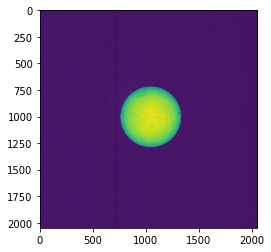

In [15]:
plt.imshow(foc)

In [32]:
F= interpolate.interp2d(y,x,foc, kind='linear')

## mapping
for y_u in range(Ny):
    for x_u in range(Nx):
          x_d, y_d = Inv2(x_c,y_c,x_u,y_u,k)
          output_inv[y_u,x_u] = F(x_d, y_d)


In [33]:
hdu = pyfits.PrimaryHDU(output_inv)
hdu.writeto(path_03+'FDT_foc_und.fits')

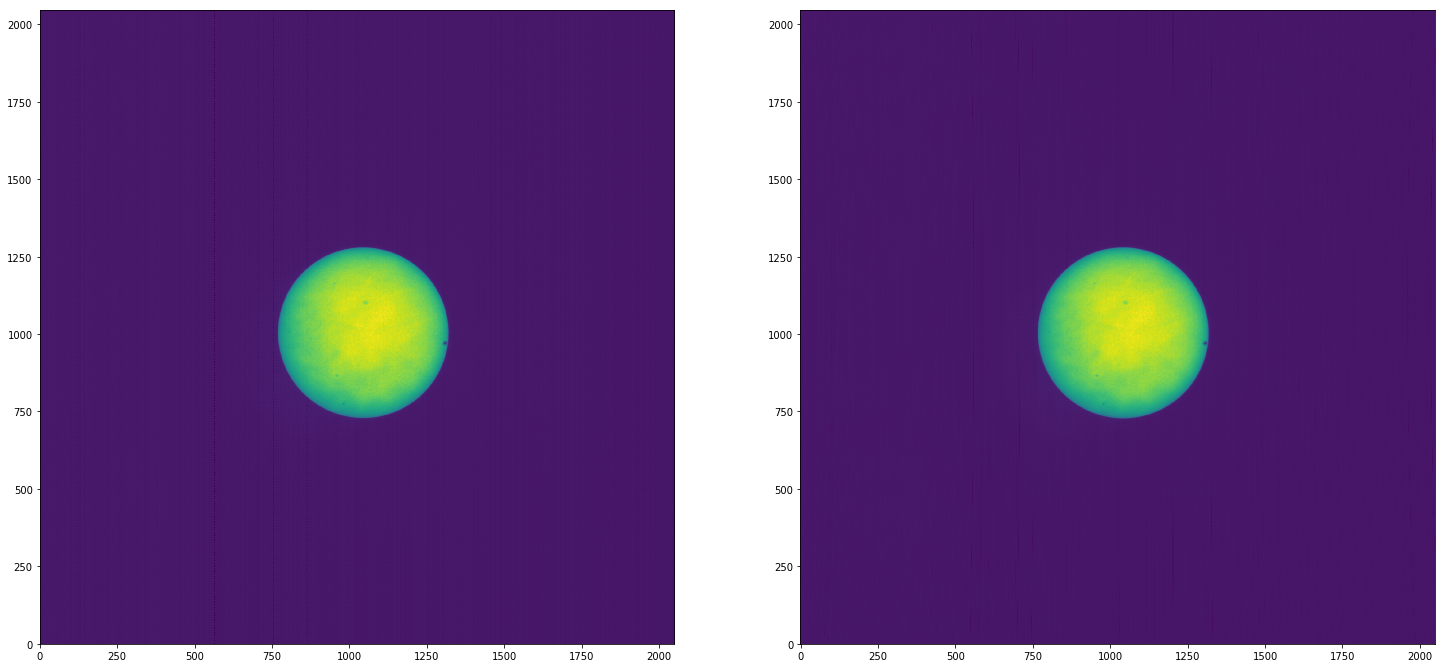

In [12]:
fig=plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(foc,origin='lower')
ax2.imshow(output_inv,origin='lower')


In [34]:
foc_un = output_inv

# platescale measurement

In [35]:
#foc = d[0,:,:] - dark[0:2048,:]

foc = foc_un[710:1310,750:1330]
foc = foc/foc.mean()

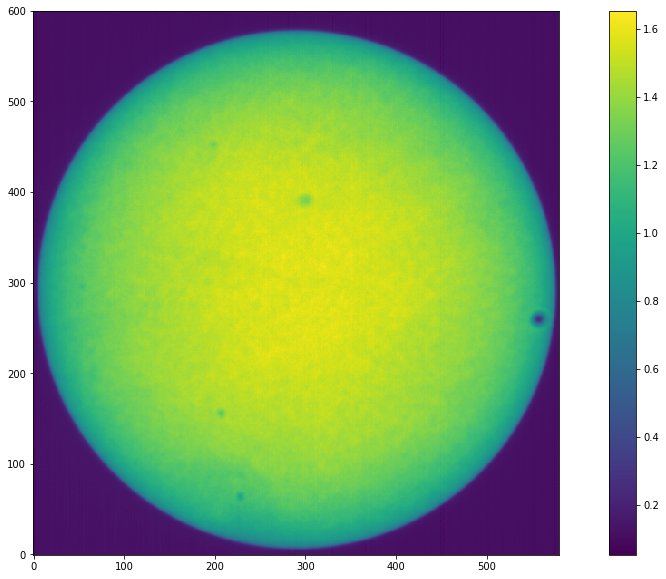

In [36]:
plt.figure(figsize=(18,10))
plt.imshow(foc,origin='lower')
plt.colorbar()

In [37]:
l1 = foc.shape[0]
l2 = foc.shape[1]
mask = np.zeros((l1,l2))
for i in range(l1):
    for j in range(l2):
        if foc[i][j] > 0.2:
            mask[i][j] = 1
        else:
            mask[i][j] = 0


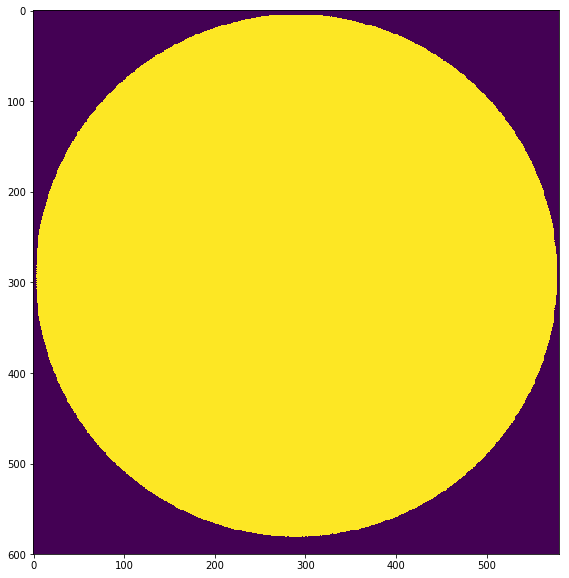

In [38]:
plt.figure(figsize=(18,10))
plt.imshow(mask)

In [30]:
from scipy.ndimage.filters import gaussian_filter as gf

mask_smooth = gf(mask,sigma=5,mode='nearest')

In [33]:
mask_2 = np.zeros((2048,2048))
for i in range(2048):
         for j in range(2048):
             if mask_smooth[i][j] > 0.9:

                   mask_2[i][j] = 1
             else:
                   mask_2[i][j] = 0

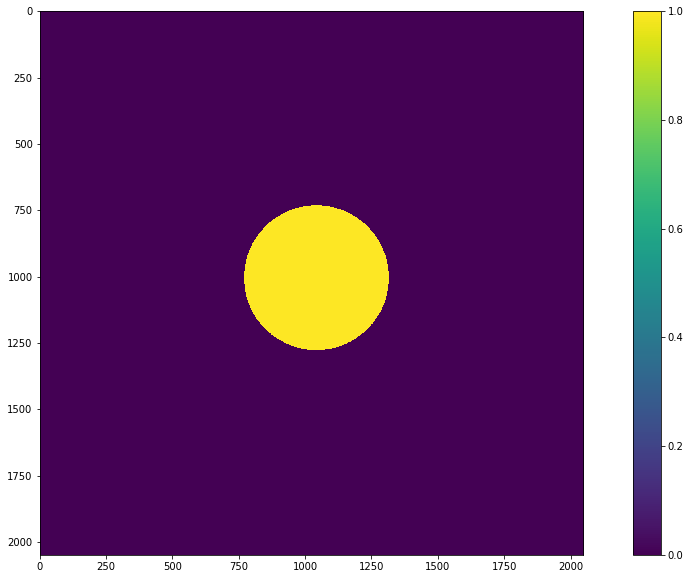

In [34]:
plt.figure(figsize=(18,10))

plt.imshow(mask_2)
plt.colorbar()

In [39]:
labels, numb = measure.label(mask,background=0, return_num=True)



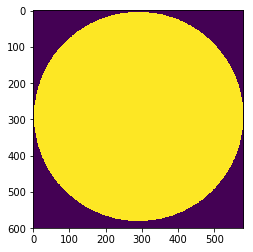

In [40]:
plt.imshow(labels)

In [41]:
props = skimage.measure.regionprops(labels)
centers = np.array([prop.centroid for prop in props])
eccen = np.array([prop.eccentricity for prop in props])
diameter = np.array([prop.equivalent_diameter for prop in props])

In [42]:
diameter

array([ 575.53532211])

In [116]:
size_sun = 206265*2*np.arctan(0.00465/0.93)

In [117]:
size_sun

2062.6328115078263

In [83]:
size_sun/574.5

3.590309506541038

In [13]:
560*7/2048.

1.9140625

191.509039222


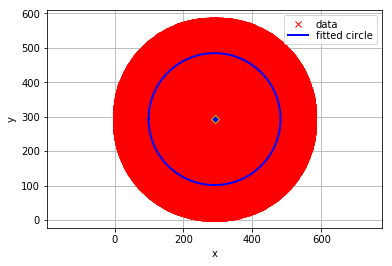

In [371]:
from scipy  import optimize


def calc_R(x,y, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()



def leastsq_circle(x_m,y_m,x,y):
    # coordinates of the barycenter
    #x_m = np.mean(x)
    #y_m = np.mean(y)
    center_estimate = x_m, y_m
    #print x_m,y_m
    center, pcov  = optimize.leastsq(f, center_estimate, args=(x,y))
    xc, yc = center
    s_sq= np.sum(f(center, x,y)**2)/(len(x)-len(center))
    pcov = pcov * s_sq    
    #err = np.sqrt(np.diag(pcov))
    Ri       = calc_R(x, y, *center)
    R        = Ri.mean()
    residu   = np.sum((Ri - R)**2)
    return xc, yc, R

def plot_data_circle(x,y, xc, yc, R):
    f = plt.figure( facecolor='white')  #figsize=(7, 5.4), dpi=72,
    plt.axis('equal')

    theta_fit = np.linspace(-np.pi, np.pi, 180)

    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.xlabel('x')
    plt.ylabel('y')   
    # plot data
    plt.plot(x, y, 'rx', label='data', mew=1)
    plt.plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2)
    plt.plot([xc], [yc], 'bD', mec='y', mew=1)
    plt.legend(loc='best',labelspacing=0.1 )

    plt.grid()
    #plt.title('Least Squares Circle')





## loop on features:
for i in np.arange(numb):
    y,x = props[i].coords[:,0], props[i].coords[:,1]
    y_m, x_m = props[i].centroid
    #yc,xc = props[i].centroid
    #R_eq = props[i].major_axis_length
    #plt.plot(x,y,'rx')
    #plt.Circle((xc,yc),R_eq/2,color='blue')
    #plt.show()
    xc, yc, R = leastsq_circle(x_m,y_m,x,y)
    print R
   # print R
  #print xc, yc
    plot_data_circle(x,y,xc,yc,R)  

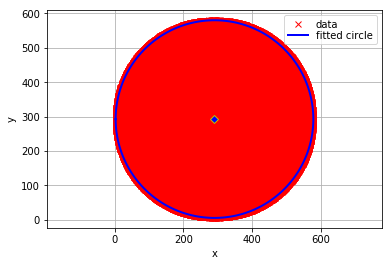

In [372]:
for i in np.arange(numb):
    y,x = props[i].coords[:,0], props[i].coords[:,1]
    R = props[i].equivalent_diameter/2.
    yc, xc = props[i].centroid
    plot_data_circle(x,y,xc,yc,R)  

## phi-FDT 

In [118]:
data = pyfits.getdata(path_fdt+'solo_L0_phi-fdt-ilam_20200519T140026_V202006061705C_0065250135.fits')

In [119]:
data.shape
foc = data[0,:,:]
defoc = data[1,:,:]

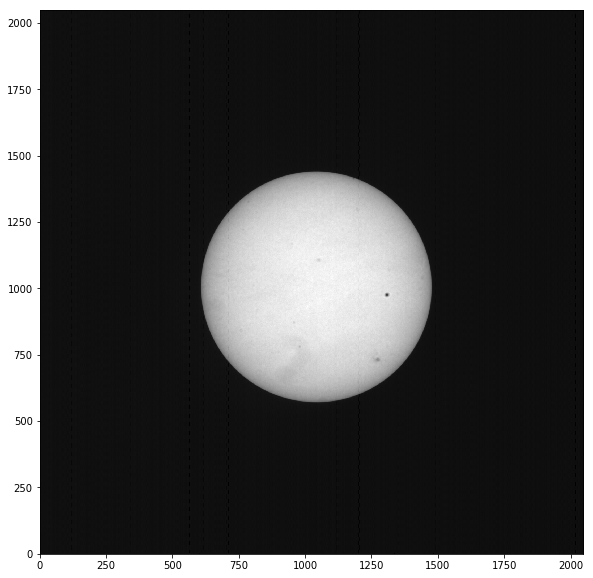

In [120]:
plt.figure(figsize=(18,10))
plt.imshow(foc,cmap='gray',origin='lower')

In [13]:
F= interpolate.interp2d(y,x,foc, kind='linear')

## mapping
for y_u in range(Ny):
    for x_u in range(Nx):
          x_d, y_d = Inv2(x_c,y_c,x_u,y_u,k)
          output_inv[y_u,x_u] = F(x_d, y_d)


In [14]:
def savefits(data,image):
    hdu = pyfits.PrimaryHDU(data)
    hdu.writeto(image)

In [17]:
savefits(foc,path_fdt+'foc.fits')

In [21]:
temp = output_inv[500:1500,550:1500]
temp = temp/temp.mean()

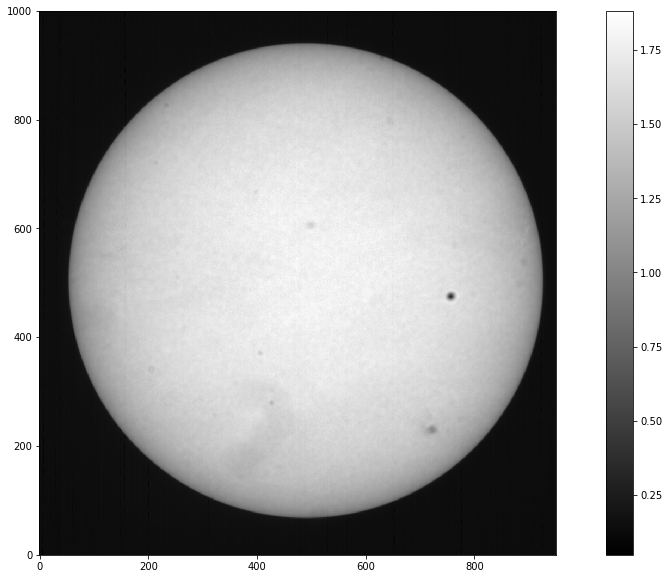

In [59]:

plt.figure(figsize=(18,10))
plt.imshow(temp,cmap='gray',origin='lower')
plt.colorbar()

In [108]:
#foc = foc[500:1500,550:1500]
#foc = foc/foc.mean()
l1 = temp.shape[0]
l2 = temp.shape[1]
mask = np.zeros((l1,l2))
for i in range(l1):
    for j in range(l2):
        if temp[i][j] > 0.2:
            mask[i][j] = 1
        else:
            mask[i][j] = 0

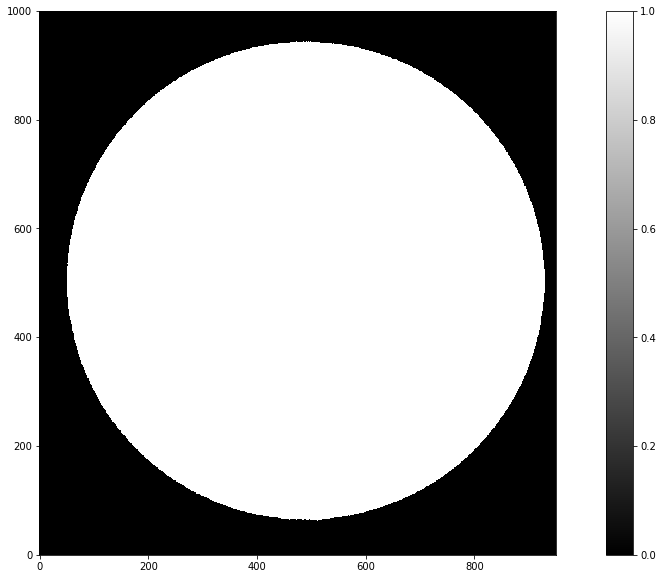

In [109]:
plt.figure(figsize=(18,10))
plt.imshow(mask,cmap='gray',origin='lower')
plt.colorbar()

In [110]:
labels, numb = measure.label(mask,background=0, return_num=True)


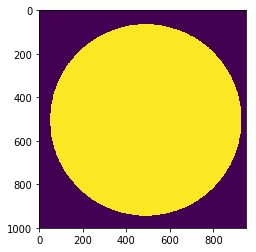

In [111]:
plt.imshow(labels)

In [112]:
props = skimage.measure.regionprops(labels)
centers = np.array([prop.centroid for prop in props])
eccen = np.array([prop.eccentricity for prop in props])
diameter = np.array([prop.equivalent_diameter for prop in props])

In [113]:
diameter

array([ 877.91379992])

In [121]:
size_sun = 206265*2*np.arctan(0.00465/0.62)

In [122]:
size_sun

3093.9169899265771

In [115]:
size_sun/diameter

array([ 3.52416945])

In [52]:
size_sun

3093.9169899265771

In [81]:
## for the distorted map: size of the disc = 874 and platescale is 3.54

In [132]:
k = 8.19580991637e-09
x_d = 1010.7216076251761
y_d = 908.11184129045171
X_d = 2000; Y_d = 2000
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))

In [133]:
X_u

2017.601452853666

In [134]:
Y_u

2019.4271077738456

In [155]:
r_d = np.sqrt((X_d-x_d)**2 + (Y_d-y_d)**2)


In [156]:
r_u = np.sqrt((X_u-x_d)**2 + (Y_u-y_d)**2)


In [157]:
r_d

array([[ 1358.75872929,  1358.09059371,  1357.42286597, ...,
         1485.6768122 ,  1486.40989186,  1487.14328258],
       [ 1358.01503718,  1357.34653553,  1356.67844157, ...,
         1484.99668252,  1485.73009776,  1486.46382388],
       [ 1357.27167435,  1356.60280639,  1355.93434598, ...,
         1484.3169149 ,  1485.05066586,  1485.78472751],
       ..., 
       [ 1340.67601737,  1339.99886562,  1339.32211816, ...,
         1469.15706766,  1469.8983862 ,  1470.64001104],
       [ 1341.41184591,  1340.7350658 ,  1340.05869012, ...,
         1469.82857716,  1470.56955719,  1471.31084373],
       [ 1342.1480161 ,  1341.47160739,  1340.79560328, ...,
         1470.50046005,  1471.2411017 ,  1471.98205004]])

In [158]:
r_u

array([[ 1379.31853086,  1378.6200809 ,  1377.92208705, ...,
         1512.55282954,  1513.32571326,  1514.09896423],
       [ 1378.54109812,  1377.84229868,  1377.14395521, ...,
         1511.83580595,  1512.60900704,  1513.38257518],
       [ 1377.7640465 ,  1377.06489734,  1376.36620401, ...,
         1511.11919782,  1511.89271641,  1512.66660187],
       ..., 
       [ 1360.42584907,  1359.71878657,  1359.01217639, ...,
         1495.14648622,  1495.92716644,  1496.70820896],
       [ 1361.19421448,  1360.48750718,  1359.78125238, ...,
         1495.85364906,  1496.63400875,  1497.41473096],
       [ 1361.96297239,  1361.25662007,  1360.5507204 , ...,
         1496.56123774,  1497.34127704,  1498.12167906]])

In [162]:
(r_u - r_d).max()

26.955681644297556

In [144]:
np.sqrt(np.sum((X_u-X_d)**2+(Y_u-Y_d)**2))

26.21495105882207

In [152]:
X_d,Y_d =np.indices([2000,2000])

In [153]:
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))

In [154]:
 np.sqrt((1./len(X_u)**2)*np.sum((X_u-X_d)**2+(Y_u-Y_d)**2))

7.0198458285232448

In [163]:
0.35/0.5

0.7

In [164]:
1/0.7

1.4285714285714286